# 1. Introduction
Objectif du notebook

Description rapide du dataset (Cityscapes, 8 classes)

Contexte embarqué (besoins de performance, taille, etc.)



 test https://karpathy.github.io/2019/04/25/recipe/


# 2. Imports & Configuration
Import des bibliothèques (TensorFlow, Keras, albumentations, etc.)

Définition des constantes (dimensions, chemins, classes cibles)

Configuration GPU (si nécessaire)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image


In [2]:
import tensorflow as tf
import numpy as np
import sys

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Python:", sys.version)


TensorFlow: 2.10.1
NumPy: 1.23.5
Python: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]


In [3]:
import tensorflow as tf
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Number of GPUs Available:  1


# 3. Chargement des données
Récupération des chemins des images et masques

Filtrage pour ne garder que les 8 classes principales

Fonction de lecture des images et masques

Visualisation d'exemples

In [4]:
# Dossier racine
base_path = "../data"

# Exemple avec une image de validation
city = "frankfurt"
image_name = "frankfurt_000000_000294_leftImg8bit.png"

# Chemins
image_path = os.path.join(base_path, "leftImg8bit", "val", city, image_name)
mask_path = os.path.join(base_path, "gtFine", "val", city, image_name.replace("leftImg8bit", "gtFine_labelIds"))

# Chargement
image = Image.open(image_path)
mask = Image.open(mask_path)

# Conversion en array
image_np = np.array(image)
mask_np = np.array(mask)


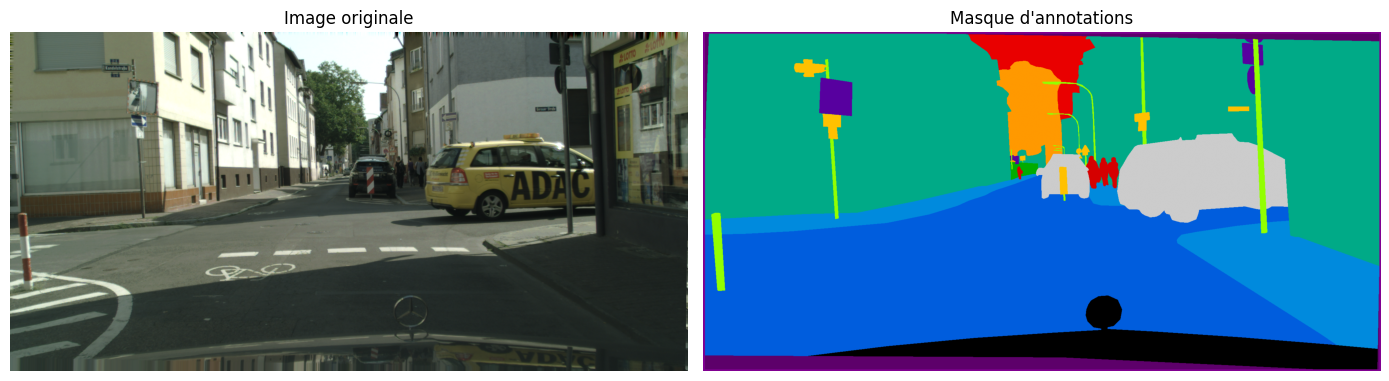

In [5]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='nipy_spectral')  # colormap perceptuelle
plt.title("Masque d'annotations")
plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
def afficher_batch_images_avec_masks(base_path, split='val', ville='frankfurt', nb_images=5):
    import random

    img_dir = os.path.join(base_path, "leftImg8bit", split, ville)
    mask_dir = os.path.join(base_path, "gtFine", split, ville)

    # On récupère toutes les images disponibles dans la ville
    all_images = [f for f in os.listdir(img_dir) if f.endswith("_leftImg8bit.png")]
    
    # Sélection aléatoire
    images_choisies = random.sample(all_images, min(nb_images, len(all_images)))

    plt.figure(figsize=(14, 4 * nb_images))

    for i, nom_image in enumerate(images_choisies):
        img_path = os.path.join(img_dir, nom_image)
        mask_path = os.path.join(mask_dir, nom_image.replace("leftImg8bit", "gtFine_labelIds"))

        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))

        plt.subplot(nb_images, 2, i * 2 + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1} - {nom_image}")
        plt.axis("off")

        plt.subplot(nb_images, 2, i * 2 + 2)
        plt.imshow(mask, cmap='nipy_spectral')
        plt.title(f"Masque {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


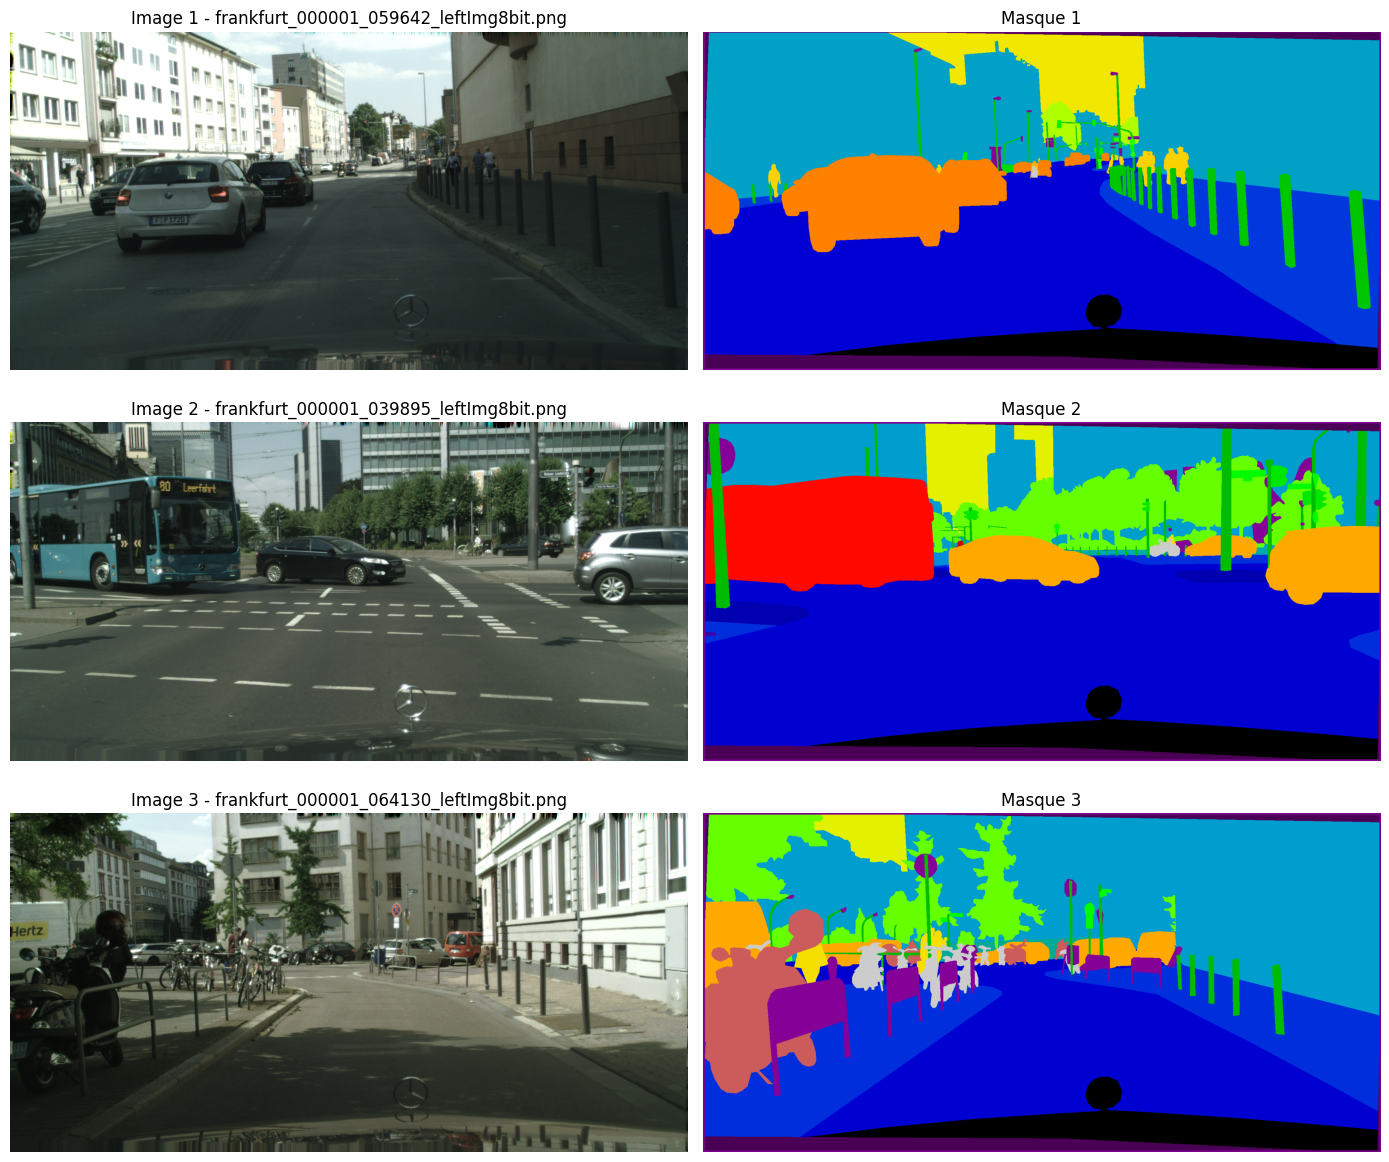

In [7]:
afficher_batch_images_avec_masks(base_path="../data", split="val", ville="frankfurt", nb_images=3)


# 4. Prétraitement et Augmentation
Redimensionnement, normalisation

Pipeline de data augmentation (albumentations)

Création d’un tf.data.Dataset ou Sequence personnalisé

Affichage d’exemples augmentés



In [8]:
def group_labels_to_8(mask):
    label_mapping = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
    }

    mapped = np.full_like(mask, 7)  # 7 = classe "void" par défaut
    for src, dst in label_mapping.items():
        mapped[mask == src] = dst
    return mapped


In [9]:
import cv2

def enhance_contrast_rgb(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[..., 0] = cv2.equalizeHist(img_yuv[..., 0])  # Histogram equalization sur Y
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

In [10]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
def preprocess(image, mode="baseline"):
    if mode == "contrast+sharpen":
        image = enhance_contrast_rgb(image)
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        image = cv2.filter2D(image, -1, kernel)

    elif mode == "equalize+vgg":
        image = enhance_contrast_rgb(image)
        image = tf.keras.applications.vgg16.preprocess_input(image.astype(np.float32))

    elif mode == "blur+edges":
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 100)
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        image = cv2.addWeighted(image, 0.7, edges_rgb, 0.3, 0)

    elif mode == "norm-1to1+contrast":
        image = image.astype(np.float32)
        image = (image / 127.5) - 1.0  # Normalisation [-1, 1]
        image = enhance_contrast_rgb(((image + 1.0) * 127.5).astype(np.uint8))
        image = image / 255.0

    else:
        image = image / 255.0  # Baseline simple

    return image

In [11]:
import keras
import os
import numpy as np
from PIL import Image
import cv2
import random

class CityscapesGenerator(keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, image_size=(256, 512),
                 augment=False, shuffle=True, preprocess_mode="baseline"):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.preprocess_mode = preprocess_mode
        self.on_epoch_end()

        self.transform = self._get_transform()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            image = np.array(Image.open(self.image_paths[i]))
            mask = np.array(Image.open(self.mask_paths[i]))
            mask = group_labels_to_8(mask)  # 🎯 remapping ici
            image = preprocess(image, mode=self.preprocess_mode)
            image = image.astype(np.float32)
            if self.augment:
                image, mask = self.transform(image, mask)

            image = image / 255.0
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
            mask = cv2.resize(mask, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_NEAREST)


            batch_images.append(image)
            batch_masks.append(mask)


        return np.array(batch_images), np.array(batch_masks)

    def _get_transform(self):
        if not self.augment:
            return lambda image, mask: (image, mask)

        def transform_fn(image, mask):
            # Flip horizontal avec une probabilité de 0.5
            if random.random() < 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

            # Shift, scale, rotate simulé avec cv2
            if random.random() < 0.5:
                h, w = image.shape[:2]
                center = (w // 2, h // 2)
                scale = 1.0 + random.uniform(-0.1, 0.1)  # ±10%
                dx = int(w * random.uniform(-0.05, 0.05))  # ±5% shift horizontal
                dy = int(h * random.uniform(-0.05, 0.05))  # ±5% shift vertical
                M = cv2.getRotationMatrix2D(center, 0, scale)
                M[:, 2] += [dx, dy]

                image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
                mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)

            return image, mask

        return transform_fn



In [12]:
def get_image_and_mask_paths(base_path, split="train", ville="aachen"):
    import glob

    img_dir = os.path.join(base_path, "leftImg8bit", split, ville)
    mask_dir = os.path.join(base_path, "gtFine", split, ville)

    # Liste uniquement les images leftImg8bit
    image_paths = sorted(glob.glob(os.path.join(img_dir, "*_leftImg8bit.png")))

    # Pour chaque image, construit le chemin du masque _labelIds
    mask_paths = [
        os.path.join(mask_dir, os.path.basename(p).replace("leftImg8bit", "gtFine_labelIds"))
        for p in image_paths
    ]
    return image_paths, mask_paths




In [13]:
img_paths, mask_paths = get_image_and_mask_paths("../data", split="train", ville="aachen")
print(img_paths[0])
print(mask_paths[0])


../data\leftImg8bit\train\aachen\aachen_000000_000019_leftImg8bit.png
../data\gtFine\train\aachen\aachen_000000_000019_gtFine_labelIds.png


In [14]:
gen1 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='baseline')
gen2 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='contrast+sharpen')
gen3 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='equalize+vgg')
gen4 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='blur+edges')
gen5 = CityscapesGenerator(img_paths, mask_paths, preprocess_mode='norm-1to1+contrast')

X_batch, y_batch = gen1[0]


print("Shape images :", X_batch.shape)
print("Shape masques :", y_batch.shape)


Shape images : (8, 256, 512, 3)
Shape masques : (8, 256, 512)


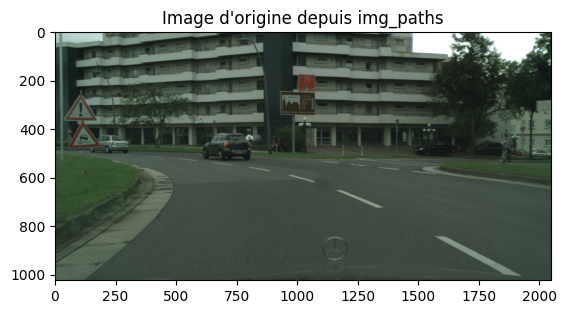

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

i = 0
raw_img = np.array(Image.open(img_paths[i]))

plt.imshow(raw_img)
plt.title("Image d'origine depuis img_paths")
plt.show()


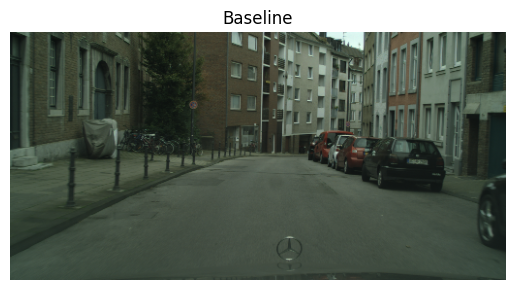

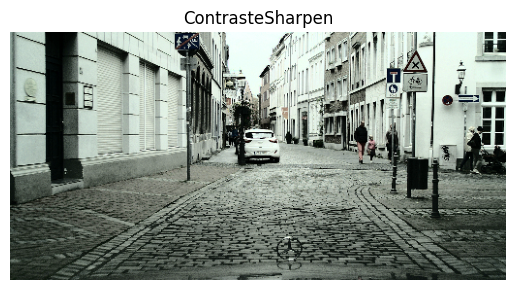

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8187421..1.0].


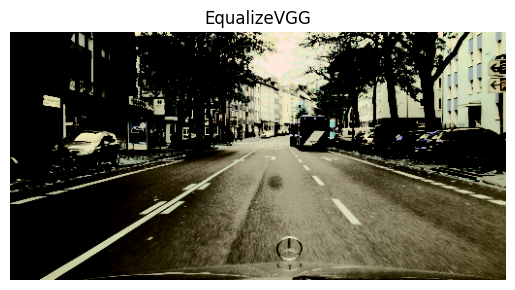

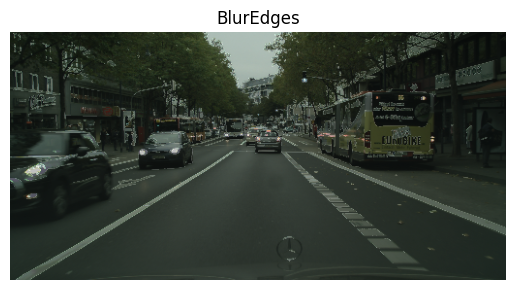

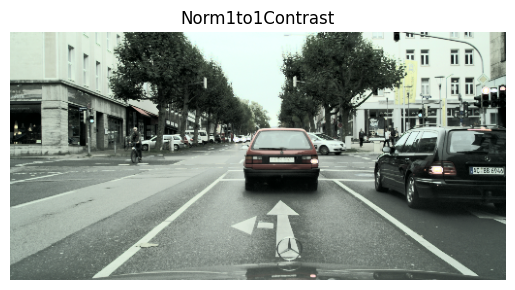

In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf

# On récupère le même index dans chaque générateur
i = 0
X1, y = gen1[i]
X2, _ = gen2[i]
X3, _ = gen3[i]
X4, _ = gen4[i]
X5, _ = gen5[i]

for img, title in zip([X1[0], X2[0], X3[0], X4[0], X5[0]], ["Baseline", "ContrasteSharpen", "EqualizeVGG", "BlurEdges", "Norm1to1Contrast"]):
    plt.figure()
    plt.imshow(img / img.max())
    plt.title(title)
    plt.axis('off')
    plt.show()



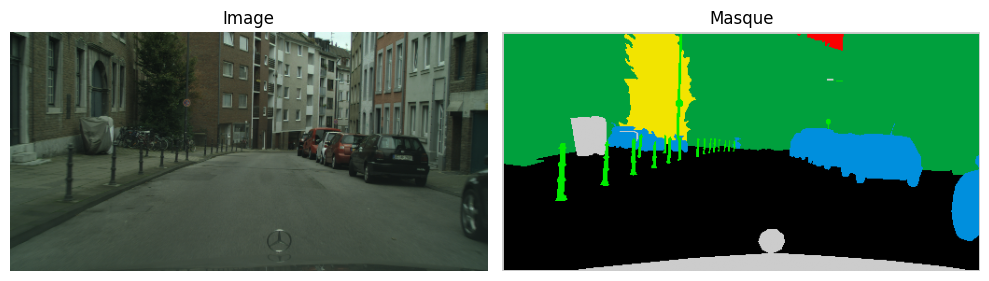

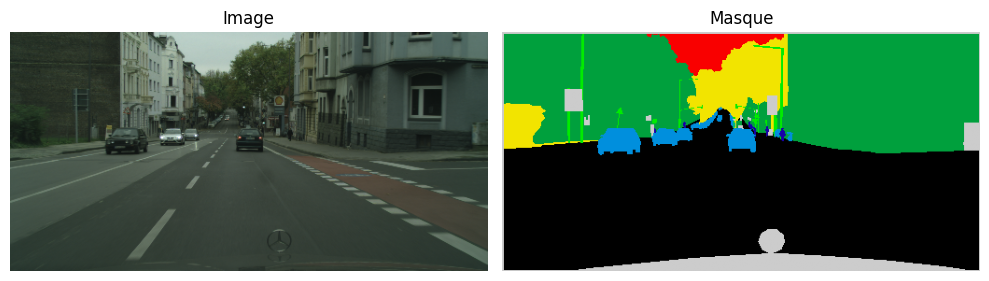

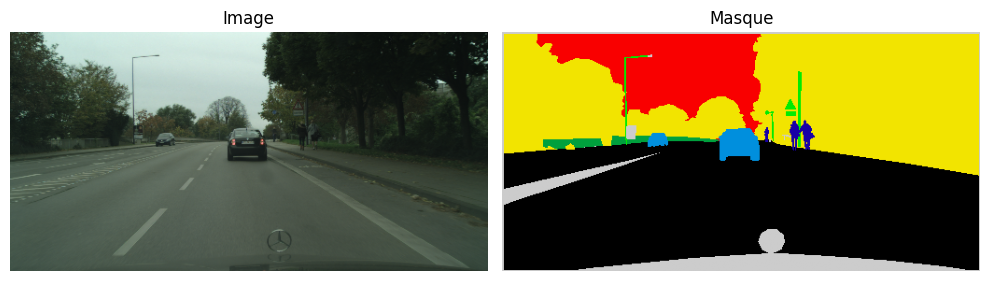

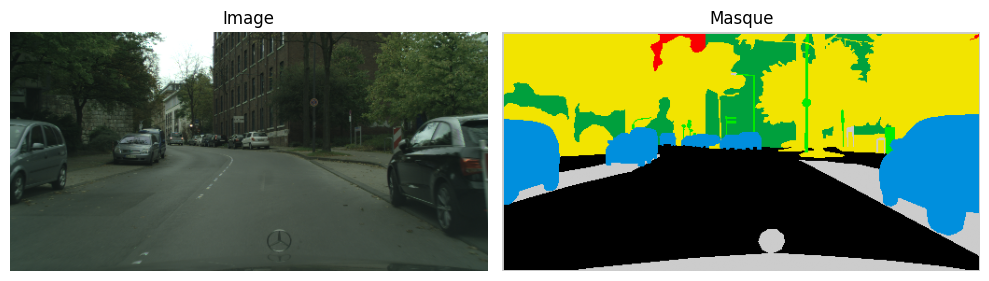

In [17]:
for i in range(4):
    plt.figure(figsize=(10, 4))

    # Image normalisée (évite l'image noire)
    plt.subplot(1, 2, 1)
    plt.imshow(X_batch[i] / X_batch[i].max())  # ou vmin=0, vmax=0.01
    plt.title("Image")
    plt.axis("off")

    # Masque
    plt.subplot(1, 2, 2)
    plt.imshow(y_batch[i], cmap="nipy_spectral")
    plt.title("Masque")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# 5. Modélisation
Définition du modèle (U-Net, DeepLabV3+, etc.)

Ajout d’une fonction de perte personnalisée (Dice loss + CrossEntropy)

Compilation du modèle avec les bonnes métriques (IoU, accuracy, etc.)

In [18]:
import os
import glob

def get_image_and_mask_paths(data_path, split):
    image_paths = []
    mask_paths = []

    cities = os.listdir(os.path.join(data_path, split))
    for city in cities:
        image_paths += sorted(glob.glob(os.path.join(data_path, split, city, "*leftImg8bit.png")))
        mask_paths += sorted(glob.glob(os.path.join(data_path.replace("leftImg8bit", "gtFine"), split, city, "*_gtFine_labelIds.png")))

    return image_paths, mask_paths


In [19]:
train_img, train_mask = get_image_and_mask_paths("../data/leftImg8bit", "train")
val_img, val_mask = get_image_and_mask_paths("../data/leftImg8bit", "val")

train_img = train_img[:400]  # Ne prendre que les 100 premières images
train_mask = train_mask[:400]

val_img = val_img[:40]       # Idem pour la validation
val_mask = val_mask[:40]


train_gen = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True)
val_gen = CityscapesGenerator(val_img, val_mask, batch_size=4, image_size=(256, 512), augment=False)


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)
]


In [21]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(256, 512, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    return models.Model(inputs=inputs, outputs=outputs)


In [22]:
gen_baseline = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='baseline')
gen_contrast = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='contrast+sharpen')
gen_edges    = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='blur+edges')
gen_vgg = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='equalize+vgg')
gen_norm = CityscapesGenerator(train_img, train_mask, batch_size=4, image_size=(256, 512), augment=True, preprocess_mode='norm-1to1+contrast')



In [23]:
results = {}

for mode, gen in zip(['baseline', 'contrast+sharpen', 'blur+edges', 'equalize+vgg', 'norm-1to1+contrast'], [gen_baseline, gen_contrast, gen_edges, gen_vgg, gen_norm]):
    print(f"🔧 Entraînement avec prétraitement: {mode}")
    
    model = unet_model(input_shape=(256, 512, 3), num_classes=8)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    history = model.fit(
        gen,
        validation_data=val_gen,
        epochs=10,  # ou plus si tu veux observer
        steps_per_epoch=100,
        callbacks=callbacks,
        verbose=1
    )
    
    results[mode] = (model, history)


🔧 Entraînement avec prétraitement: baseline
Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.6545 - accuracy: 0.3697
Epoch 1: val_loss improved from inf to 1.60558, saving model to best_model.h5
100/100 [==============================] - 76s 641ms/step - loss: 1.6545 - accuracy: 0.3697 - val_loss: 1.6056 - val_accuracy: 0.4450
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.5575 - accuracy: 0.3962
Epoch 2: val_loss did not improve from 1.60558
100/100 [==============================] - 62s 620ms/step - loss: 1.5575 - accuracy: 0.3962 - val_loss: 1.6075 - val_accuracy: 0.4558
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.5525 - accuracy: 0.4055
Epoch 3: val_loss improved from 1.60558 to 1.59297, saving model to best_model.h5
100/100 [==============================] - 64s 634ms/step - loss: 1.5525 - accuracy: 0.4055 - val_loss: 1.5930 - val_accuracy: 0.4279
Epoch 4/10
100/100 [==============================] - ETA: 

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(gen, model, title=""):
    X, y_true = gen[0]
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=-1)

    i = 0  # premier exemple

    # 🔧 Normalisation dynamique pour affichage propre
    image_to_show = X[i]
    image_to_show = (image_to_show - image_to_show.min()) / (image_to_show.max() - image_to_show.min())

    # Récupération des classes prédite
    pred_classes = np.unique(y_pred_classes[i])
    true_classes = np.unique(y_true[i])

    plt.figure(figsize=(12, 4))

    # Image d'entrée
    plt.subplot(1, 3, 1)
    plt.imshow(image_to_show)
    plt.title(f"{title} - Image")
    plt.axis("off")

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(y_true[i], cmap="nipy_spectral")
    plt.title(f"{title} - Vrai masque\nClasses : {true_classes.tolist()}")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_classes[i], cmap="nipy_spectral")
    plt.title(f"{title} - Masque prédit\nClasses : {pred_classes.tolist()}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 21ms/step


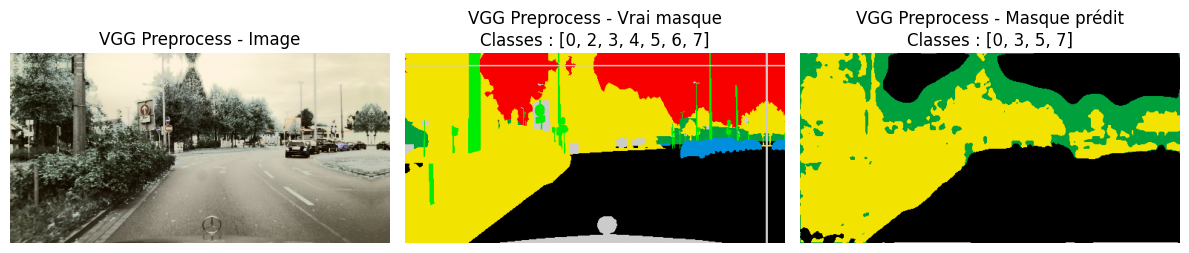

1/1 [==============================] - 0s 21ms/step


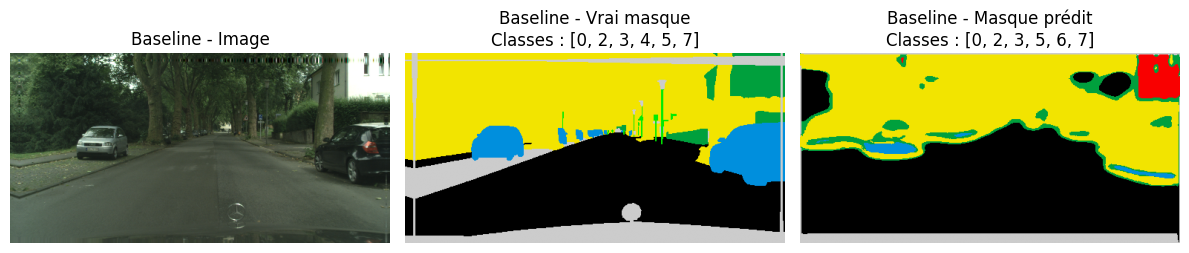

1/1 [==============================] - 0s 22ms/step


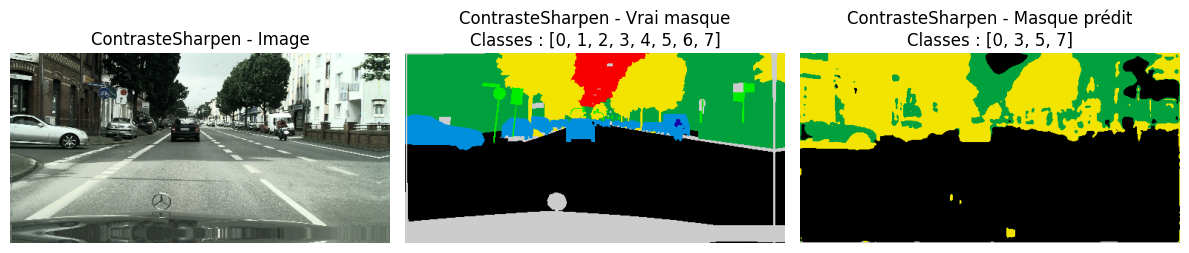

1/1 [==============================] - 0s 22ms/step


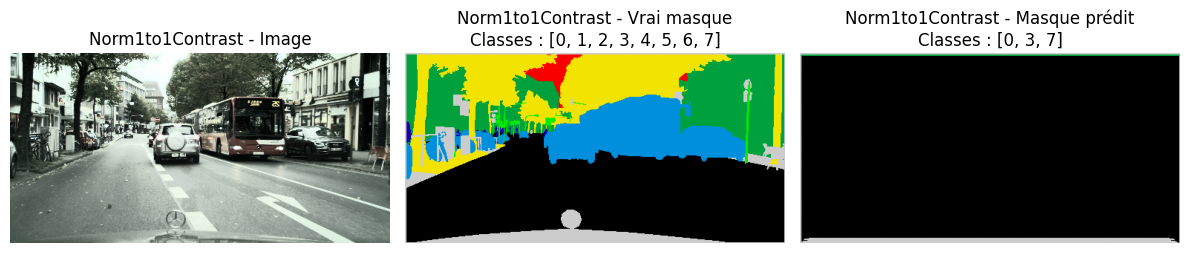

1/1 [==============================] - 0s 21ms/step


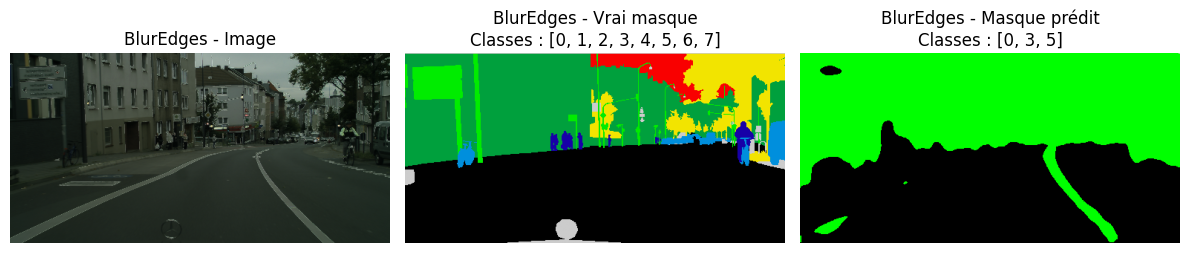

In [31]:
# On récupère les bons modèles
model_baseline, _ = results['baseline']
model_contrast, _ = results['contrast+sharpen']
model_edges, _ = results['blur+edges']
model_vgg, _ = results['equalize+vgg']
model_norm, _ = results['norm-1to1+contrast']
show_predictions(gen_vgg, model_vgg, "VGG Preprocess")

# Et on affiche les prédictions
show_predictions(gen_baseline, model_baseline, "Baseline")
show_predictions(gen_contrast, model_contrast, "ContrasteSharpen")
show_predictions(gen_norm, model_norm, "Norm1to1Contrast")
show_predictions(gen_edges, model_edges, "BlurEdges")


# 6. Entraînement
Split train/val

Définition des callbacks (ModelCheckpoint, ReduceLROnPlateau, etc.)

Lancement de l'entraînement

Affichage des courbes d’évolution (loss, IoU, etc.)

# 7. Évaluation
Prédictions sur le set de validation

Affichage visuel des résultats (image, masque réel, masque prédit)

Calcul de métriques globales et par classe

# 8. Optimisation
Test d’autres architectures ou backbone (MobileNetV2, etc.)

Essais de réglages (batch size, learning rate)

Comparaison des performances



# 9. Conclusion
Résumé des résultats

Points forts et limites du modèle

Prochaines étapes (ex : export TFLite, intégration dans API, embarqué, etc.)

In [32]:
import tensorflow as tf
print(tf.__version__)


2.10.1
